In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from datasets import load_dataset
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/yvson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yvson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
def get_balanced_dataset(dataset, percentage):
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 
    dataset = pd.DataFrame(dataset)
    dataset = dataset[['text', 'label']]
    dataset = dataset.groupby("label").apply(lambda x: x.sample(frac=percentage)).reset_index(drop=True)
    return dataset

In [6]:
dataset = load_dataset("told-br")
Categories = ['Non-toxic', 'Toxic']
perc_train = 1
perc = 1

train_df = get_balanced_dataset(dataset["train"], perc_train)
teste_df = get_balanced_dataset(dataset["test"], perc)

/home/yvson/Documents/Faculdade/NLP/NLP-final-project/venv/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for told-br contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/told-br
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [7]:
def text_preprocess(ds: pd.Series) -> pd.Series:
    
    for m in range(len(ds)):
        
        main_words = re.sub('[^a-zA-Z]', ' ', ds[m])                                      # Retain only alphabets
        main_words = (main_words.lower()).split()
        main_words = [w for w in main_words if not w in set()]  # Remove stopwords
        
        lem = WordNetLemmatizer()
        main_words = [lem.lemmatize(w) for w in main_words if len(w) > 1]                 # Group different forms of the same word
        
        main_words = ' '.join(main_words)
        ds[m] = main_words

    return ds

In [8]:
train_df['text'] = text_preprocess(train_df['text'])
teste_df['text'] = text_preprocess(teste_df['text'])

In [10]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(train_df["text"].to_list())
tfidf_test = tfidf_vectorizer.transform(teste_df["text"].to_list())

train_df['text_tfdif'] = list(tfidf_train.toarray())
teste_df['text_tfdif'] = list(tfidf_test.toarray())

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(list(train_df["text_tfdif"]), train_df["label"])

LogisticRegression()

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

y_hat = model.predict(list(teste_df["text_tfdif"]))
y_test = teste_df["label"].to_list()

In [13]:
#compute accuracy
accuracy = sum([y_hat[i] == y_test[i] for i in range(len(y_test))]) / len(y_test)
print(f"Accuracy: {accuracy}")

#compute recall
recall = recall_score(y_test, y_hat, average='macro')
print(f"Recall: {recall}")

#compute precision
precision = precision_score(y_test, y_hat, average='macro')
print(f"Precision: {precision}")

#compute f1 score
f1 = f1_score(y_test, y_hat, average='macro')
print(f"F1 Score: {f1}")

Accuracy: 0.7257142857142858
Recall: 0.7193546974870852
Precision: 0.7275982678214523
F1 Score: 0.7203066268091278


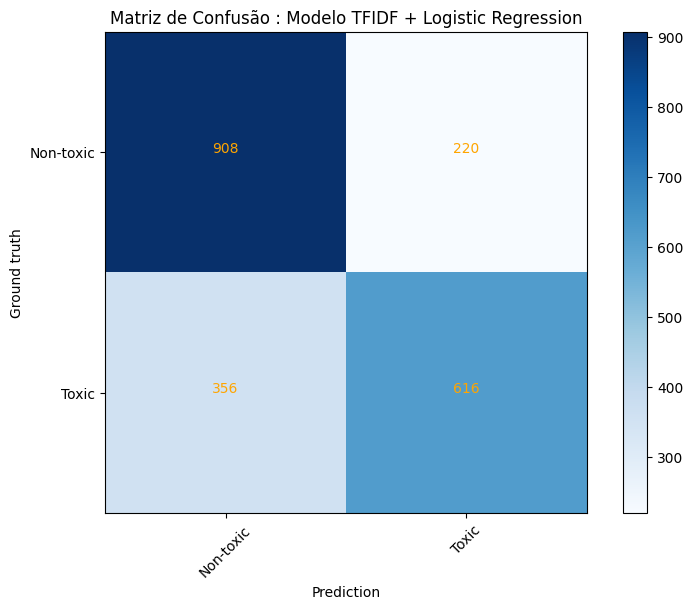

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(y_test, y_hat)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão : Modelo TFIDF + Logistic Regression')
plt.colorbar()


tick_marks = np.arange(len(Categories))
plt.xticks(tick_marks, Categories, rotation=45)
plt.yticks(tick_marks, Categories)


thresh = conf_matrix.max() / 2.
for i, j in [(i, j) for i in range(conf_matrix.shape[0]) for j in range(conf_matrix.shape[1])]:
    plt.text(j, i, conf_matrix[i, j], horizontalalignment="center", color="orange" if conf_matrix[i, j] > thresh else "orange")

plt.tight_layout()
plt.ylabel('Ground truth')
plt.xlabel('Prediction')
plt.show()